# Coin Metrics

## Case Study 

Coin Metrics publishes several network metrics and no single metric can fully represent activity on the network. 

The large number of metrics also makes it difficult to understand the current state of economic activity. 

Therefore, we would like you to construct an aggregate growth index for Bitcoin: a single, easily-interpretable timeseries that comprehensively measures how fast a network is growing.

The ideal aggregate growth index would use several of our existing network metrics as inputs and allow a user to determine whether a network is experiencing positive or negative growth as well as the magnitude of the growth. 

The index should be comparable across time (allow a user to measure growth today versus some time in the past) and across cryptoassets (allow a user to compare the growth of Bitcoin versus Ethereum).

<b>The final output of your case study should be a timeseries representing an aggregate growth index for Bitcoin.</b>

# Exploratory Data Analysis 

In [6]:
# import libraries 
import numpy as np
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
%matplotlib inline  
import plotly.express as px
from ipywidgets import interact,interactive, fixed, interact_manual
import math
import datetime
from datetime import timedelta, date
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns

In [7]:
# read data file for bitcoin metrics used in index drop unused, convert time to datetime, and setindex
cm = (pd.read_csv('asset_metrics.csv')
      .drop(['AdrBalNtv0.001Cnt','AdrBalNtv0.01Cnt','AdrBalNtv0.1Cnt','AdrBalNtv100Cnt','AdrBalNtv100KCnt',
              'AdrBalNtv10Cnt','AdrBalNtv10KCnt','AdrBalNtv1Cnt','AdrBalNtv1KCnt','AdrBalNtv1MCnt',
              'AdrBalUSD100Cnt','AdrBalUSD100KCnt','AdrBalUSD10Cnt','AdrBalUSD10KCnt','AdrBalUSD10MCnt',
              'AdrBalUSD1Cnt','AdrBalUSD1KCnt','AdrBalUSD1MCnt','AssetEODCompletionTime',
              'BlkWghtMean','BlkWghtTot','FeeTotNtv','SplyAdrBalUSD1','SplyAdrBalUSD10','SplyAdrBalUSD100',
              'SplyAdrBalUSD100K','SplyAdrBalUSD10K','SplyAdrBalUSD10M','SplyAdrBalUSD1K',
              'SplyAdrBalUSD1M','VtyDayRet180d','ROI1yr','IssContPctAnn','IssTotUSD','RevHashNtv','RevHashRateNtv',
              'RevNtv','FeeByteMeanNtv','FeeMeanNtv','FeeMedNtv','SplyMiner0HopAllNtv',
              'SplyMiner1HopAllNtv','TxTfrValAdjNtv','TxTfrValMeanNtv','TxTfrValMedNtv',
              'AdrBal1in100KCnt','AdrBal1in100MCnt','AdrBal1in10BCnt','BlkCnt','BlkSizeMeanByte',
              'AdrBal1in10KCnt','AdrBal1in10MCnt','AdrBal1in1BCnt','AdrBal1in1KCnt','RevHashRateUSD',
              'AdrBal1in1MCnt', 'SplyAdrTop100','SplyAdrTop10Pct','SplyAdrTop1Pct',
              'PriceBTC','SplyAdrBal1in100K','SplyAdrBal1in100M','SplyAdrBal1in10B',
              'SplyAdrBal1in10K','SplyAdrBal1in10M','SplyAdrBal1in1B','SplyAdrBal1in1K',
              'SplyAdrBal1in1M',],axis = 1)
      .rename(columns={'time':'Date'})
      .assign(Date = lambda x: x.Date.str[0:20]))
cm = cm.set_index('Date')
cm.index = pd.to_datetime(cm.index)
cm.shape

(4823, 66)

In [8]:
# information on data 
cm.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4823 entries, 2009-01-03 to 2022-03-18
Data columns (total 66 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   AdrActCnt            4822 non-null   float64
 1   AdrBalCnt            4822 non-null   float64
 2   CapAct1yrUSD         4261 non-null   float64
 3   CapMVRVCur           4261 non-null   float64
 4   CapMVRVFF            4261 non-null   float64
 5   CapMrktCurUSD        4261 non-null   float64
 6   CapMrktFFUSD         4261 non-null   float64
 7   CapRealUSD           4822 non-null   float64
 8   DiffLast             4816 non-null   float64
 9   DiffMean             4816 non-null   float64
 10  FeeMeanUSD           4261 non-null   float64
 11  FeeMedUSD            4261 non-null   float64
 12  FeeTotUSD            4261 non-null   float64
 13  HashRate             4816 non-null   float64
 14  HashRate30d          4787 non-null   float64
 15  IssContNtv          

In [9]:
# view start date 
pd.set_option('display.max_columns', 200)
display(cm.head(2))

,AdrActCnt,AdrBalCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeMeanUSD,FeeMedUSD,FeeTotUSD,HashRate,HashRate30d,IssContNtv,IssContPctDay,IssContUSD,IssTotNtv,NDF,NVTAdj,NVTAdj90,NVTAdjFF,NVTAdjFF90,PriceUSD,ROI30d,RevAllTimeUSD,RevHashUSD,RevUSD,SER,SplyAct10yr,SplyAct180d,SplyAct1d,SplyAct1yr,SplyAct2yr,SplyAct30d,SplyAct3yr,SplyAct4yr,SplyAct5yr,SplyAct7d,SplyAct90d,SplyActEver,SplyActPct1yr,SplyAdrBalNtv0.001,SplyAdrBalNtv0.01,SplyAdrBalNtv0.1,SplyAdrBalNtv1,SplyAdrBalNtv10,SplyAdrBalNtv100,SplyAdrBalNtv100K,SplyAdrBalNtv10K,SplyAdrBalNtv1K,SplyAdrBalNtv1M,SplyCur,SplyExpFut10yr,SplyFF,SplyMiner0HopAllUSD,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,VelCur1yr,VtyDayRet30d
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2009-01-04,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [10]:
# check for missing data and null values
total_missing = cm.isnull().sum().sort_values(ascending=False)
percent_missing = (cm.isnull().sum()/cm.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
NVTAdjFF90,652,0.135186
NVTAdj90,651,0.134978
ROI30d,592,0.122745
VtyDayRet30d,592,0.122745
CapMVRVFF,562,0.116525
IssContUSD,562,0.116525
SplyMiner0HopAllUSD,562,0.116525
SplyMiner1HopAllUSD,562,0.116525
TxTfrValAdjUSD,562,0.116525
TxTfrValMeanUSD,562,0.116525


# Index Construction 

<b>Initial Index Components</b>

- 3 segments:
    - Network Health 
        - Growth (Active Addresses, New Addresses)
        - Usage (Transaction Count, Transaction Volume)
        - Security (Hash Rate, Miner Revenue and Profitability)
        - Monetary Integrity (Circulating Supply and Issuance Rate)
    - Market Dynamics 
        - Trading (Exchange Deposits, Exchange Balances: N/A in API data provided but show in Dictionary)
        - Transactions (Volume: No data available in API Data provided)
        - Valuation (MVRV and NVT)
    - Paricipant Sentiment 
        - Investor Sentiment (Accumulation and Distribution, SOPR N/A in data provided)
        - Saving Behavior (HODL Waves, SER)
        - Supply Ratio (LTH to STH Supply Ratio)

## Create Index Metrics

In [11]:
# view end date 
display(cm.tail(2))

,AdrActCnt,AdrBalCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeMeanUSD,FeeMedUSD,FeeTotUSD,HashRate,HashRate30d,IssContNtv,IssContPctDay,IssContUSD,IssTotNtv,NDF,NVTAdj,NVTAdj90,NVTAdjFF,NVTAdjFF90,PriceUSD,ROI30d,RevAllTimeUSD,RevHashUSD,RevUSD,SER,SplyAct10yr,SplyAct180d,SplyAct1d,SplyAct1yr,SplyAct2yr,SplyAct30d,SplyAct3yr,SplyAct4yr,SplyAct5yr,SplyAct7d,SplyAct90d,SplyActEver,SplyActPct1yr,SplyAdrBalNtv0.001,SplyAdrBalNtv0.01,SplyAdrBalNtv0.1,SplyAdrBalNtv1,SplyAdrBalNtv10,SplyAdrBalNtv100,SplyAdrBalNtv100K,SplyAdrBalNtv10K,SplyAdrBalNtv1K,SplyAdrBalNtv1M,SplyCur,SplyExpFut10yr,SplyFF,SplyMiner0HopAllUSD,SplyMiner1HopAllUSD,TxCnt,TxCntSec,TxTfrCnt,TxTfrValAdjUSD,TxTfrValMeanUSD,TxTfrValMedUSD,VelCur1yr,VtyDayRet30d
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-17,1009859.0,40861411.0,2.896110e+11,1.69308,1.306139,7.777970e+11,6.000370e+11,4.593980e+11,2.745270e+13,2.751780e+13,1.550989,0.433834,422965.1312,217498770.5,198040848.2,993.75,0.005234,40710376.83,993.75,0.340704,74.965768,57.250511,57.83287,44.16631,40966.41693,-7.965265,4.074262e+10,0.000002,41133341.96,0.08472,16522106.18,4670318.041,523797.3987,7069480.165,10482318.26,1877954.004,11738039.03,13200750.02,14621349.78,863230.1769,3189634.481,17209845.51,37.234801,18979319.82,18940888.44,18737556.65,17943262.68,16221018.57,11963316.01,663636.9217,2787191.549,8044134.709,0.0,18986217.18,20661607.81,14647050.99,7.372855e+10,1.055100e+11,272685.0,3.156076,876433.0,1.037537e+10,28397.46431,96.037162,15.323794,0.044772
2022-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41826.11607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Create growth index features
# Monetary Integrity: total circulating supply/daily issuance and issuance rate
cm['MonInt'] = cm.SplyCur/cm.IssContNtv
# Security: hash rate/miner revenue, hash rate and miner revenue (percent change)
cm['NetSec'] = cm.HashRate/cm.RevAllTimeUSD
# Stock to Flow - adjusted supply/daily new supply 
# LTH: Old Supply (1y-2y)
cm['LTH'] = cm.SplyAct1yr + cm.SplyAct2yr
# STH: New Supply (1w-1m)
cm['STH'] = cm.SplyAct7d + cm.SplyAct30d
# LTH to STH Supply Ratio
cm['LTH_STH'] = cm.LTH/cm.STH
# Market Cap to Thermocap Ratio: market cap/all-time miner revenue in USD
cm['MC_MR'] = cm.CapMrktCurUSD/cm.RevAllTimeUSD
# Miner Profitability: holdings and revenue 
cm['MnrHld'] = cm.SplyMiner0HopAllUSD + cm.SplyMiner1HopAllUSD
# Usage - active addresses,transaction count and transaction volume (percent change)

In [13]:
# Distribution over time using balance greater than or less than 10k native  
cm['SpAB_L10k'] = (cm['SplyAdrBalNtv0.001'] + cm['SplyAdrBalNtv0.01'] + cm['SplyAdrBalNtv0.1'] + 
                   cm['SplyAdrBalNtv1'] + cm['SplyAdrBalNtv10'] + cm['SplyAdrBalNtv100'] + cm['SplyAdrBalNtv1K'])
cm['SpAB_G10k'] = (cm['SplyAdrBalNtv100K'] + cm['SplyAdrBalNtv10K'] + cm['SplyAdrBalNtv1K'] + cm['SplyAdrBalNtv1M'])

In [14]:
# HODL Waves aggregates and stacks the following active supply bands in relative proportion
# to the total coin supply:1d-1w 1w-1m 1-3m 3-6m 6-12 1-2y 2-3y 3-5y 5-10y
cm['Sply_A1D_1W'] = (cm['SplyAct1d'] + cm['SplyAct7d'])/cm['SplyActEver']
cm['Sply_A1M_3M'] = (cm['SplyAct30d'] + cm['SplyAct90d'] - cm['Sply_A1D_1W'])/cm['SplyActEver']
cm['Sply_A3M_6M'] = (cm['SplyAct180d'] - cm['SplyAct90d'])/cm['SplyActEver']
cm['Sply_A6M-1Y'] = (cm['SplyAct1yr'] - cm['SplyAct180d'])/cm['SplyActEver']
cm['Sply_A1Y_2Y'] = (cm['SplyAct2yr'] - cm['SplyAct1yr'])/cm['SplyActEver']
cm['Sply_A2Y_3Y'] = (cm['SplyAct3yr'] - cm['SplyAct2yr'])/cm['SplyActEver']
cm['Sply_A3Y_5Y'] = (cm['SplyAct5yr'] - cm['SplyAct3yr'])/cm['SplyActEver']
cm['Sply_A5Y_10Y'] = (cm['SplyAct10yr'] - cm['SplyAct5yr'])/cm['SplyActEver']

In [15]:
# Stock to Flow is a number that shows how many years, at the current production rate, 
# are required to achieve the current stock
cm['SF'] = cm.SplyFF/cm.IssContNtv.rolling(window=365).sum()
cm['SFP'] = round(math.exp(-1.84) * cm['SF']**3.36,2)
cm['SFR'] = cm.PriceUSD/cm.SFP
# Peak Growth: puell multiple
cm['PM'] = cm.IssContNtv/cm.IssContNtv.rolling(window=365).sum()

In [16]:
# Drop unused columns 
cm = (cm.drop(['SplyAct10yr',
                 'SplyAct180d',
                 'SplyAct1d',
                 'SplyAct1yr',
                 'SplyAct2yr',
                 'SplyAct30d',
                 'SplyAct3yr',
                 'SplyAct4yr',
                 'SplyAct5yr',
                 'SplyAct7d',
                 'SplyAct90d',
                 'SplyActEver',
                 'SplyActPct1yr',
                 'SplyAdrBalNtv0.001',
                 'SplyAdrBalNtv0.01',
                 'SplyAdrBalNtv0.1',
                 'SplyAdrBalNtv1',
                 'SplyAdrBalNtv10',
                 'SplyAdrBalNtv100',
                 'SplyAdrBalNtv100K',
                 'SplyAdrBalNtv10K',
                 'SplyAdrBalNtv1K',
                 'SplyAdrBalNtv1M',
                 'SF',
                 'SFP',
                 'TxTfrValMedUSD',
                 'SplyMiner0HopAllUSD',
                 'SplyMiner1HopAllUSD',
                 'ROI30d',
                 'FeeMedUSD',
                 'TxCntSec',
                 'CapMVRVCur',
                 'CapMVRVFF',
                 'CapAct1yrUSD',
                 'SplyFF',
                 'CapMrktFFUSD',
                 'DiffMean',
                 'FeeMeanUSD',
                 'HashRate',
                 'NVTAdjFF',
                 'NVTAdjFF90',
                 'RevUSD',
                 'CapMrktCurUSD',
                 'CapRealUSD',
                 'TxTfrValMeanUSD',
                 'VelCur1yr',
                 'PriceUSD',
                 'VtyDayRet30d'], axis = 1)
                 .dropna())
display(cm.shape)
cm.tail(2)

(4172, 39)

,AdrActCnt,AdrBalCnt,DiffLast,FeeTotUSD,HashRate30d,IssContNtv,IssContPctDay,IssContUSD,IssTotNtv,NDF,NVTAdj,NVTAdj90,RevAllTimeUSD,RevHashUSD,SER,SplyCur,SplyExpFut10yr,TxCnt,TxTfrCnt,TxTfrValAdjUSD,MonInt,NetSec,LTH,STH,LTH_STH,MC_MR,MnrHld,SpAB_L10k,SpAB_G10k,Sply_A1D_1W,Sply_A1M_3M,Sply_A3M_6M,Sply_A6M-1Y,Sply_A1Y_2Y,Sply_A2Y_3Y,Sply_A3Y_5Y,Sply_A5Y_10Y,SFR,PM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-16,1014991.0,40824425.0,2.755030e+13,421369.3261,198530516.2,968.75,0.005103,39817338.31,968.75,0.340132,45.118808,57.072503,4.070238e+10,0.000002,0.084744,18985223.43,20661359.38,276789.0,859260.0,1.729492e+10,19597.649992,0.005215,1.757624e+07,2.627606e+06,6.689069,19.171509,1.796365e+11,1.108158e+08,1.149007e+07,0.074331,0.285735,0.088962,0.141979,0.197305,0.072730,0.167593,0.110434,0.751433,0.002940
2022-03-17,1009859.0,40861411.0,2.745270e+13,422965.1312,198040848.2,993.75,0.005234,40710376.83,993.75,0.340704,74.965768,57.250511,4.074262e+10,0.000002,0.084720,18986217.18,20661607.81,272685.0,876433.0,1.037537e+10,19105.627351,0.005338,1.755180e+07,2.741184e+06,6.402999,19.090502,1.792385e+11,1.108295e+08,1.149496e+07,0.080595,0.294459,0.086037,0.139406,0.198307,0.072965,0.167538,0.110446,0.750022,0.003015


## Review for Seasonality

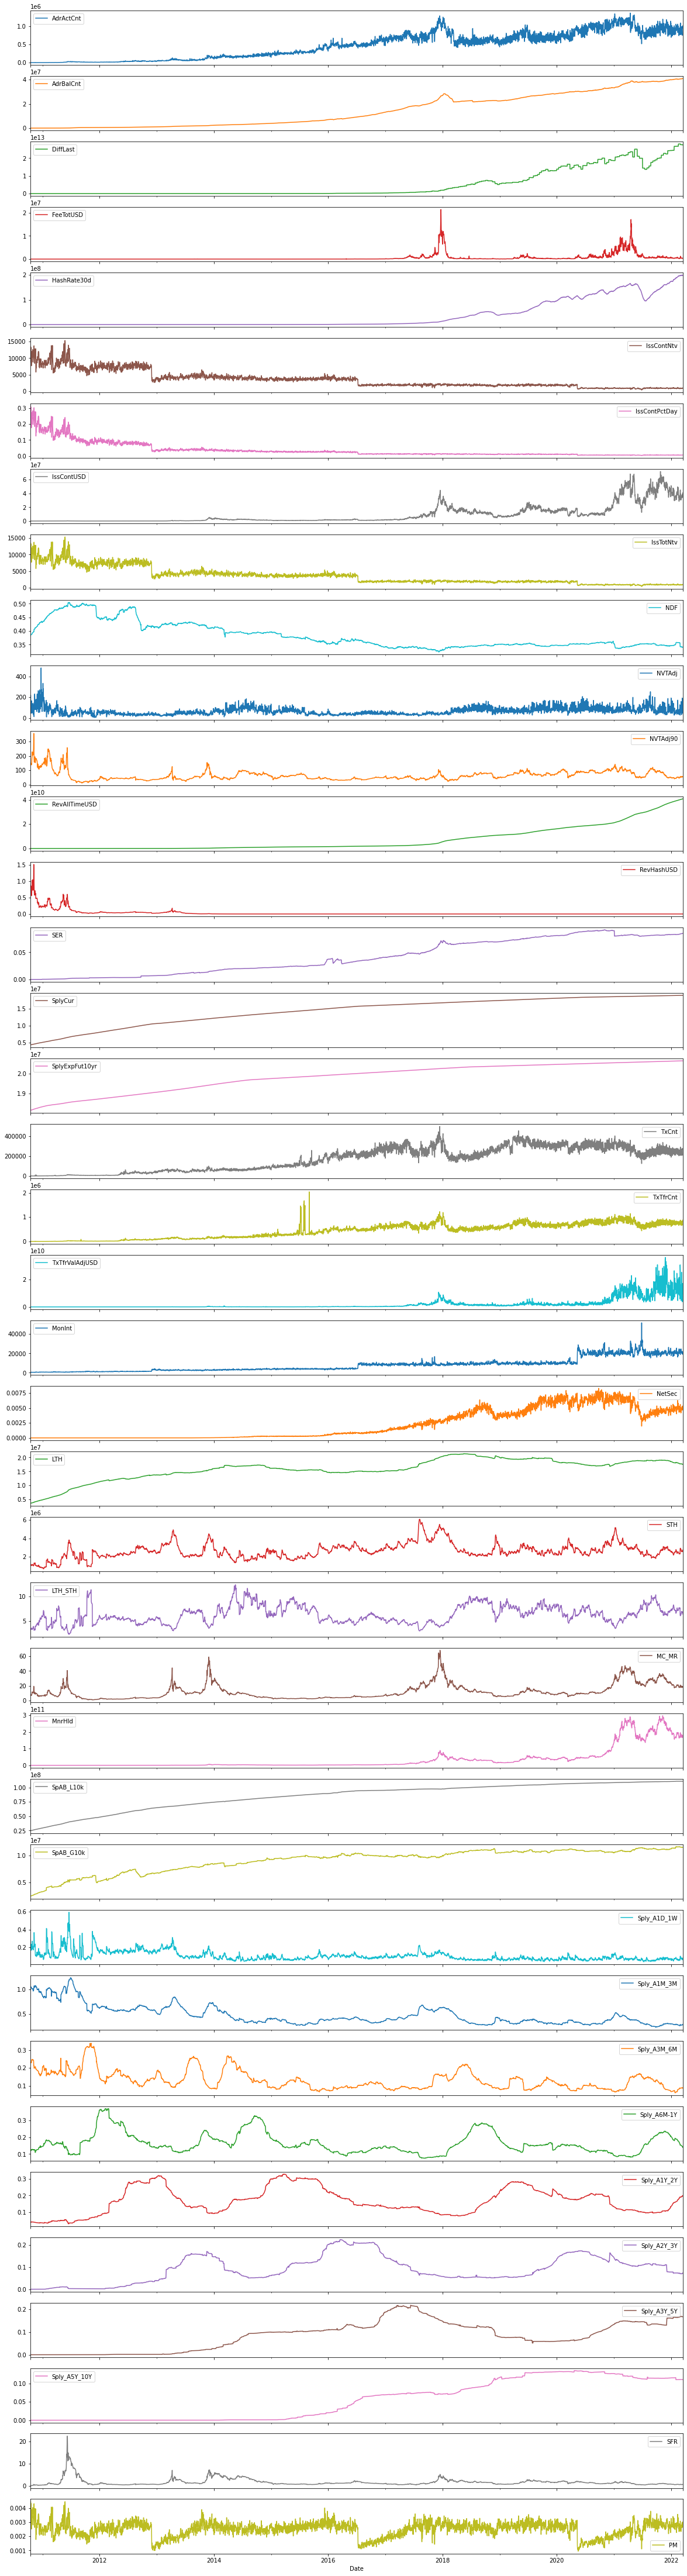

In [17]:
# plot metrics for seasonality 
plt.rcParams["figure.figsize"] = (20,80)
cm.plot(subplots=True, legend=True)
plt.show();

In [18]:
# plot metrics for seasonality 
# for i in cm.columns:
#     plt.figure()
#     plt.plot(cm[i])

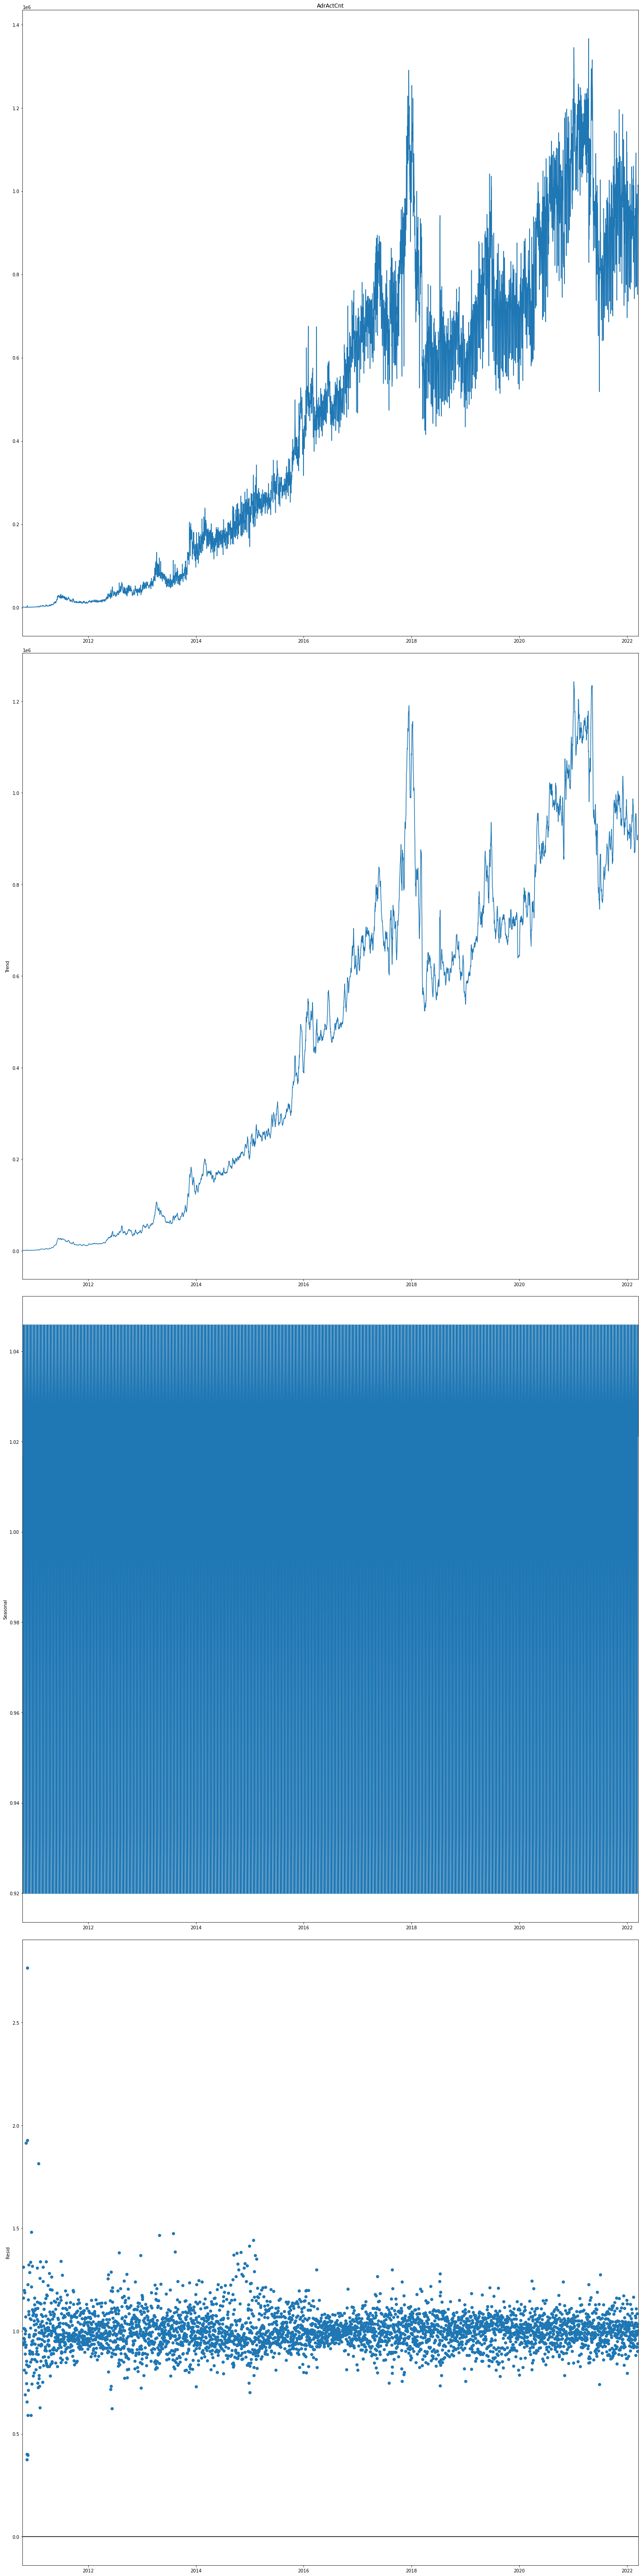

In [19]:
# check for seasonality on addresses,transactions and transfers
decompose_result = seasonal_decompose(cm.AdrActCnt, model="multiplicative")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

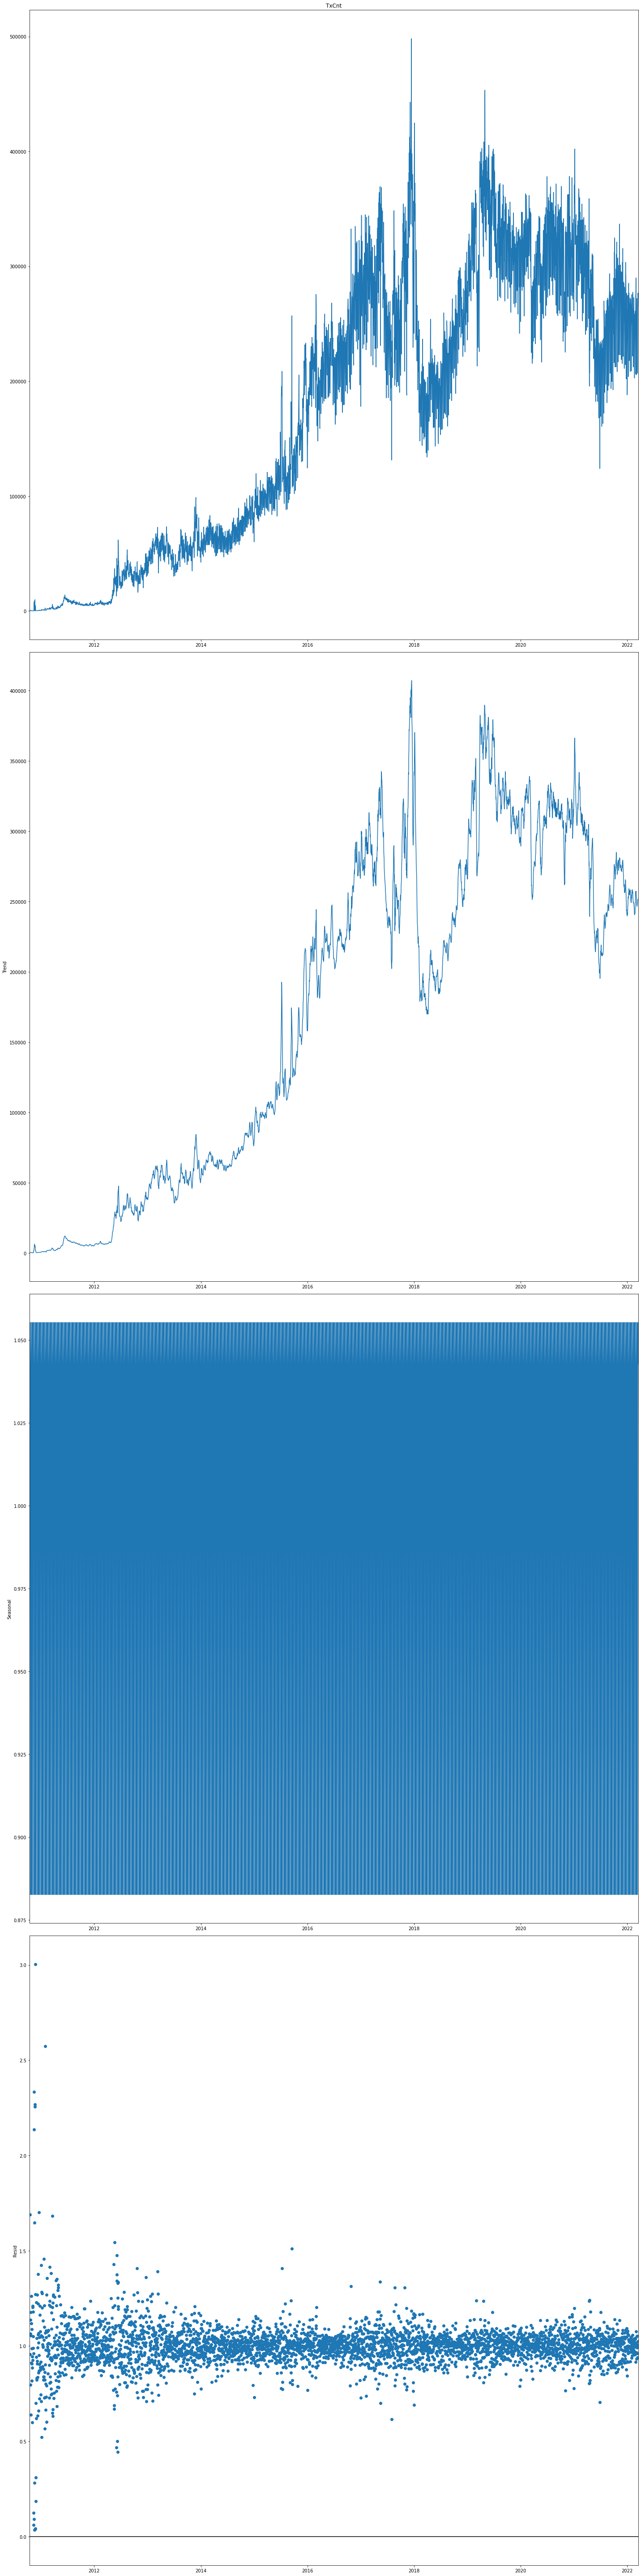

In [20]:
# check for seasonality on transactions
decompose_result = seasonal_decompose(cm.TxCnt, model="multiplicative")

trend = decompose_result.trend
seasonal = decompose_result.seasonal
residual = decompose_result.resid

decompose_result.plot();

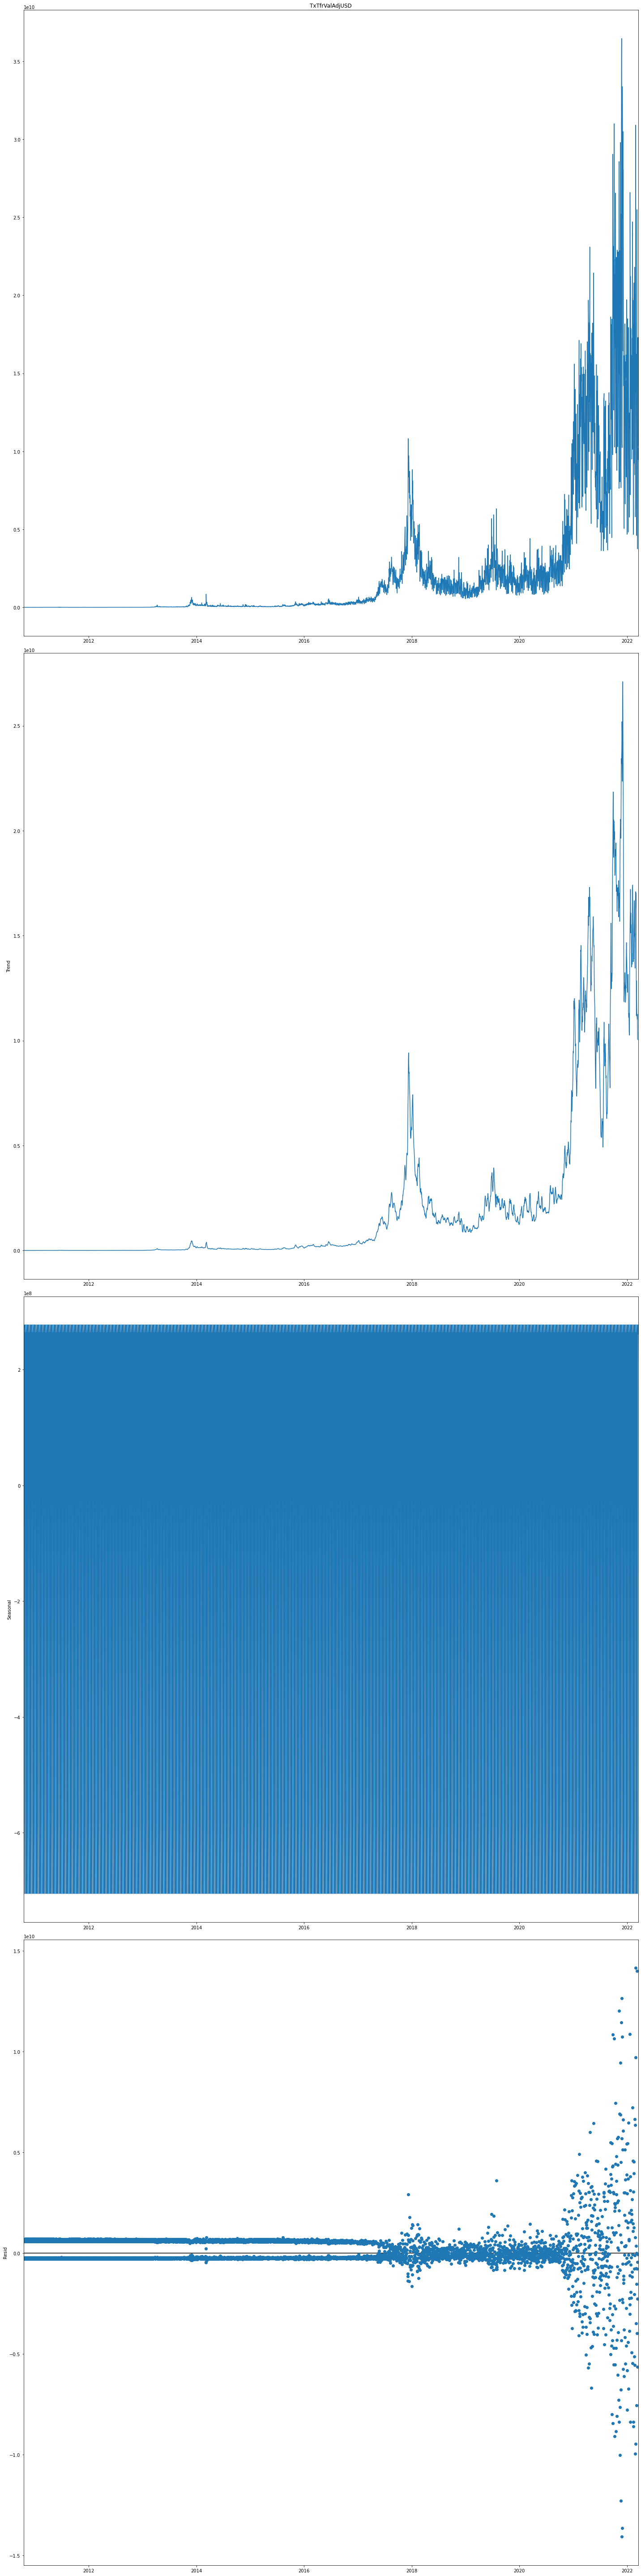

In [21]:
# check for seasonality on transfers
decompose_result = seasonal_decompose(cm.TxTfrValAdjUSD)

decompose_result.plot();

In [22]:
# Adjust for Seasonality 
cm['TxCntMA'] = cm.TxCnt.rolling(90).mean()
cm['TxCntDT'] = cm.TxCnt - cm.TxCntMA
cm['TxTfrValMA'] = cm.TxTfrValAdjUSD.rolling(90).mean()
cm['TxTfrValDT'] = cm.TxTfrValAdjUSD - cm.TxTfrValMA
cm['AdrActCntMA'] = cm.AdrActCnt.rolling(90).mean()
cm['AdrActCntDT'] = cm.AdrActCnt - cm.AdrActCntMA
dtcm = cm[['TxCntDT','TxTfrValDT','AdrActCntDT']]
display(dtcm.shape)
dtcm.tail(2)

(4172, 3)

,TxCntDT,TxTfrValDT,AdrActCntDT
Date,,,
2022-03-16,25461.477778,3.622379e+09,91070.255556
2022-03-17,21217.855556,-3.210492e+09,85595.433333


In [23]:
# add columns for percent change (stationary metrics)
cmd = cm[['AdrBalCnt', 'DiffLast', 'FeeTotUSD', 'HashRate30d',
       'IssContNtv', 'IssContPctDay', 'IssContUSD', 'IssTotNtv', 'NDF',
       'NVTAdj', 'RevAllTimeUSD', 'RevHashUSD', 'SER',
       'SplyCur', 'SplyExpFut10yr', 'TxTfrCnt',
       'MonInt', 'NetSec', 'MC_MR', 'MnrHld','SFR', 'PM']].copy()
for col in cmd.columns:
    cmd[col+'_C'] = cmd[col].pct_change()
# remove columns
cmd = cmd.loc[:,cmd.columns.str.endswith('_C')]
display(cmd.shape)
cmd.tail(2)

(4172, 22)

,AdrBalCnt_C,DiffLast_C,FeeTotUSD_C,HashRate30d_C,IssContNtv_C,IssContPctDay_C,IssContUSD_C,IssTotNtv_C,NDF_C,NVTAdj_C,RevAllTimeUSD_C,RevHashUSD_C,SER_C,SplyCur_C,SplyExpFut10yr_C,TxTfrCnt_C,MonInt_C,NetSec_C,MC_MR_C,MnrHld_C,SFR_C,PM_C
Date,,,,,,,,,,,,,,,,,,,,,,
2022-03-16,0.000719,0.000000,0.075767,0.001560,0.115108,0.115051,0.164548,0.115108,-0.003831,-0.428055,0.000000,0.043432,0.000216,0.000051,0.000012,0.039286,-0.103180,0.115108,0.044389,0.041437,0.044895,0.114981
2022-03-17,0.000906,-0.003543,0.003787,-0.002466,0.025806,0.025753,0.022428,0.025806,0.001682,0.661519,0.000989,-0.002302,-0.000278,0.000052,0.000012,0.019986,-0.025106,0.023583,-0.004225,-0.002215,-0.001879,0.025359


In [24]:
# merge detrended, differenced and percentage metrics
sply = cm[['SpAB_L10k', 'SpAB_G10k', 'Sply_A1D_1W', 'Sply_A1M_3M', 'Sply_A3M_6M',
        'Sply_A6M-1Y', 'Sply_A1Y_2Y', 'Sply_A2Y_3Y', 'Sply_A3Y_5Y','Sply_A5Y_10Y','LTH_STH']]
sply.shape
cmd = pd.merge(cmd,dtcm,left_index=True, right_index=True)
cm = pd.merge(cmd,sply,left_index=True, right_index=True).iloc[1:,:]
display(cm.shape)
btcgi = cm.copy()
btcgi[['FeeTotUSD_C','TxCntDT', 'TxTfrValDT','AdrActCntDT','Sply_A2Y_3Y','Sply_A3Y_5Y', 'Sply_A5Y_10Y']] = btcgi[['FeeTotUSD_C','TxCntDT', 'TxTfrValDT','AdrActCntDT','Sply_A2Y_3Y','Sply_A3Y_5Y', 'Sply_A5Y_10Y']].fillna(method='bfill')
btcgi = btcgi.drop(['DiffLast_C', 'FeeTotUSD_C','Sply_A2Y_3Y','Sply_A3Y_5Y', 'Sply_A5Y_10Y',],axis=1)
btcgi.tail(2)

(4171, 36)

,AdrBalCnt_C,HashRate30d_C,IssContNtv_C,IssContPctDay_C,IssContUSD_C,IssTotNtv_C,NDF_C,NVTAdj_C,RevAllTimeUSD_C,RevHashUSD_C,SER_C,SplyCur_C,SplyExpFut10yr_C,TxTfrCnt_C,MonInt_C,NetSec_C,MC_MR_C,MnrHld_C,SFR_C,PM_C,TxCntDT,TxTfrValDT,AdrActCntDT,SpAB_L10k,SpAB_G10k,Sply_A1D_1W,Sply_A1M_3M,Sply_A3M_6M,Sply_A6M-1Y,Sply_A1Y_2Y,LTH_STH
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-03-16,0.000719,0.001560,0.115108,0.115051,0.164548,0.115108,-0.003831,-0.428055,0.000000,0.043432,0.000216,0.000051,0.000012,0.039286,-0.103180,0.115108,0.044389,0.041437,0.044895,0.114981,25461.477778,3.622379e+09,91070.255556,1.108158e+08,1.149007e+07,0.074331,0.285735,0.088962,0.141979,0.197305,6.689069
2022-03-17,0.000906,-0.002466,0.025806,0.025753,0.022428,0.025806,0.001682,0.661519,0.000989,-0.002302,-0.000278,0.000052,0.000012,0.019986,-0.025106,0.023583,-0.004225,-0.002215,-0.001879,0.025359,21217.855556,-3.210492e+09,85595.433333,1.108295e+08,1.149496e+07,0.080595,0.294459,0.086037,0.139406,0.198307,6.402999


# Bitcoin Growth Index

In [80]:
# create index base  
cmgi = btcgi.copy()
cmgi['BTC_GI'] = abs(cmgi.mean(axis=1))
cmgi = cmgi[['BTC_GI']]
metrics_indexrow=cmgi[:1]
for col in cmgi:
    cmgi[col+'_indexed']=(cmgi['BTC_GI']/ metrics_indexrow['BTC_GI'][0])*1
# select only indexed columns
cmgi = (cmgi.loc[:,cmgi.columns.str.endswith('_indexed')])

Bitcoin Growth Index


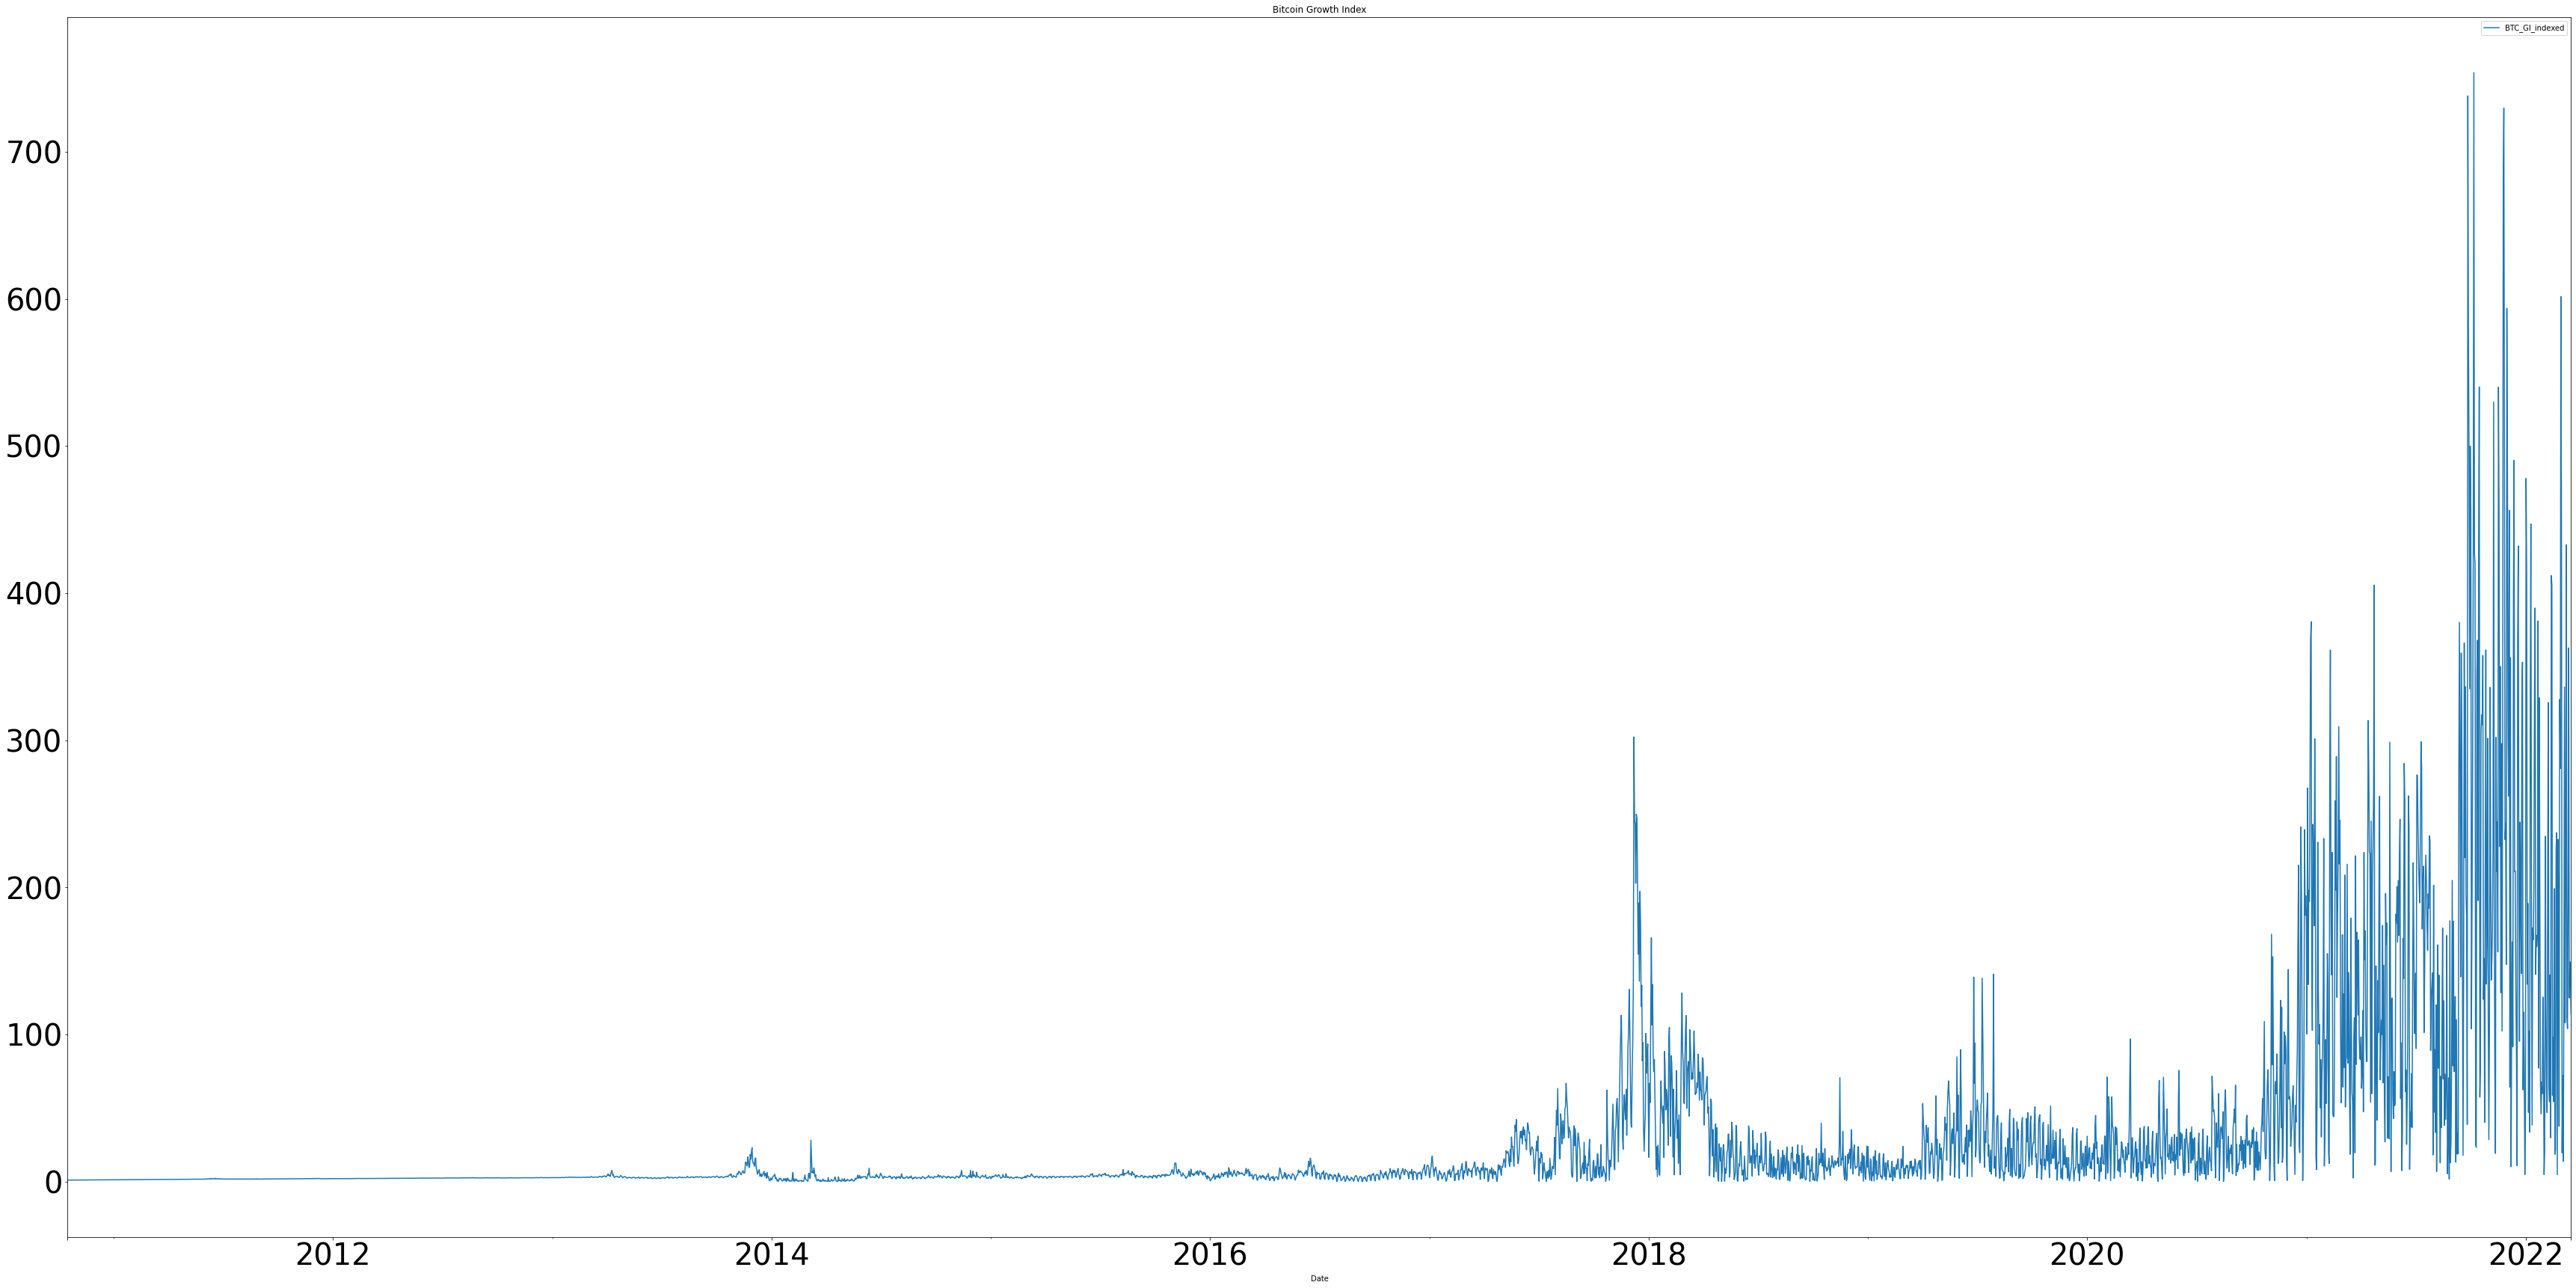

In [81]:
# plot growth index 
print('Bitcoin Growth Index')
ax = cmgi.plot(title='Bitcoin Growth Index',figsize=(60,30), fontsize=40)
plt.show()

<b> Summary </b>

The Bitcoin Growth Index demonstrates the nascent network usage and adoption from genesis until 2017 then seeks to identify the periods where user acceptance increased and decreased over the past 5 years.

The Index Components consist of Health and User behavior:
* Network Health
    - Growth (Active Addresses, New Addresses)
    - Usage (Transaction Count, Transaction Volume)
    - Security (Hash Rate, Miner Revenue and Profitability)
    - Monetary Integrity (Circulating Supply and Issuance Rate)
* Participant Sentiment 
    - Investor Sentiment (Accumulation and Distribution, SOPR N/A in data provided)
    - Saving Behavior (HODL Waves, SER)
    - Supply Ratio (LTH to STH Supply Ratio)